In [1]:
import numpy as np
import dapy.inference as da
import dapy.inference.pou as pou
from dapy.models import KuramotoSivashinskyModel
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

## Model

Partial differential equation defined on a spatial domain $s \in [0,2\pi \ell]$ due to Kuramoto [1] and Sivashinksy [2]

\begin{equation}
  \frac{\mathrm{d} z(s, t)}{\mathrm{d}t} = 
  -\left( \frac{\partial^2}{\partial s^2} + \frac{\partial^4}{\partial s^4} \right) z(s, t) -
  \frac{1}{2} \frac{\partial}{\partial s} \left( z(s, t)^2 \right)
\end{equation}

with periodic boundary conditions
\begin{equation}
  z(0, t) = z(2\pi\ell, t),~ 
  \frac{\mathrm{d} z(0, t)}{\mathrm{d}t}  =  \frac{\mathrm{d} z(2\pi\ell, t)}{\mathrm{d}t} 
  \qquad \forall t \in \mathbb{R}.
\end{equation}

Model in discretised in space on grid of $N$ equally spaced grid-points $s_j = j \frac{2\pi\ell}{N} ~~\forall j \in \lbrace 1 \dots N \rbrace$ and an FFT based spectral method used to approximate the spatial derivatives. An exponential time-differencing fourth-order Runge-Kutta method is used for the discretisation in time [3, 4].


### References

  1. Kuramoto and Tsuzuki. Persistent propagation of concentration waves
     in dissipative media far from thermal equilibrium.
     Progress in Theoretical Physcs, 55 (1976) pp. 356–369.
  2. Sivashinsky. Nonlinear analysis of hydrodynamic instability in laminar
     flames I. Derivation of basic equations.
     Acta Astronomica, 4 (1977) pp. 1177–1206.
  3. Kassam, Aly-Khan and Trefethen, Lloyd N.
     Fourth-order time-stepping for stiff PDEs.
     SIAM Journal on Scientific Computing 26.4 (2005): 1214-1233.
  4. Cox, Steven M. and Matthews, Paul C.
     Exponential time differencing for stiff systems.
     Journal of Computational Physics 176.2 (2002): 430-455.

In [2]:
n_steps = 1000
seed = 20180212
rng = np.random.RandomState(seed)
params = {
    'n_grid': 512,
    'l_param': 16,
    'dt': 0.25,
    'n_steps_per_update': 4,
    'obser_noise_std': 0.5,
    'obs_subsample': 8,
    'init_state_ampl_scale': 5.,
    'state_noise_ampl_scale': 0.1,
    'state_noise_length_scale': 1.
}
locals().update(params)
model = KuramotoSivashinskyModel(rng=rng, **params)

## Generate data from model

In [3]:
z_reference, x_reference = model.generate(n_steps)

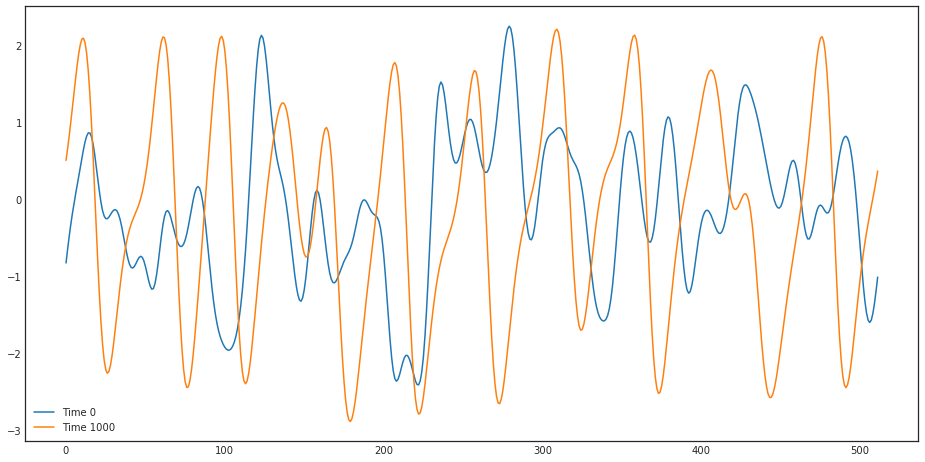

In [4]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
_ = ax.plot(z_reference[0, :].T, label='Time 0')
_ = ax.plot(z_reference[-1, :].T, label='Time {0:.0f}'.format(n_steps * dt * n_steps_per_update))
ax.legend()

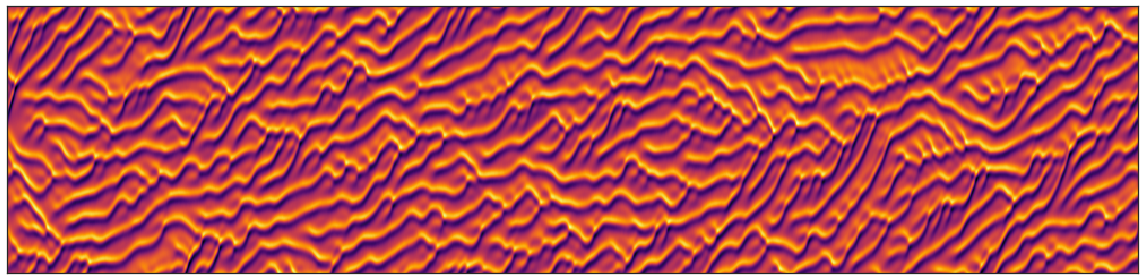

In [5]:
fig, ax = plt.subplots(
    1, 1, squeeze=True, figsize=(16, 4), sharex=True,
    subplot_kw=dict(xticks=[], yticks=[]))
ax.imshow(z_reference[:, :].squeeze().T, cmap='inferno')
ax.set_aspect('auto')
fig.tight_layout()

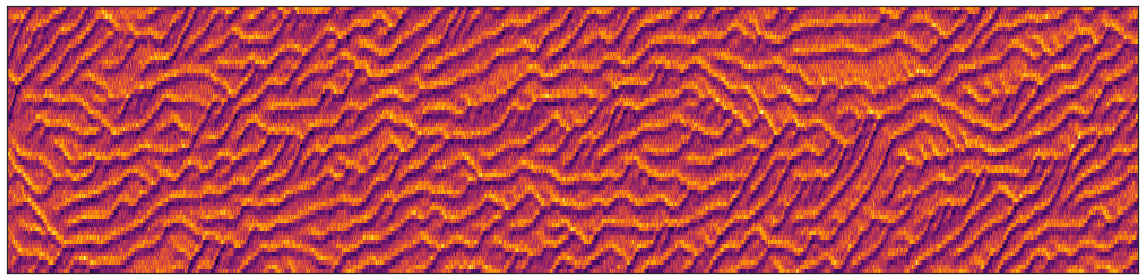

In [6]:
fig, ax = plt.subplots(
    1, 1, squeeze=True, figsize=(16, 4), sharex=True,
    subplot_kw=dict(xticks=[], yticks=[]))
ax.imshow(x_reference[:, :].squeeze().T, cmap='inferno')
ax.set_aspect('auto')
fig.tight_layout()

## Infer state from observations

In [7]:
def plot_results(results, dim_indices, z_reference=None, 
                 plot_traces=False, plot_region=True, 
                 trace_skip=1, trace_alpha=0.25):
    n_index = len(dim_indices)
    fig, axes = plt.subplots(nrows=n_index, ncols=1, sharex=True, 
                             figsize=(12, n_index * 3))
    for i, ax in zip(dim_indices, axes):
        ax.plot(results['z_mean_seq'][:, i], 'g-', lw=1)
        if plot_region:
            ax.fill_between(
                np.arange(n_steps),
                results['z_mean_seq'][:, i] - 3 * results['z_std_seq'][:, i],
                results['z_mean_seq'][:, i] + 3 * results['z_std_seq'][:, i],
                alpha=0.25, color='g'
            )
        if plot_traces:
            ax.plot(results['z_particles_seq'][:, ::trace_skip, i], 
                    'r-', lw=0.25, alpha=trace_alpha)
        if z_reference is not None:
            ax.plot(z_reference[:, i], 'k--')
        ax.set_ylabel('State at grid point {0}'.format(i))
    ax.set_xlabel('Time index $t$')
    fig.tight_layout()
    return fig, axes

### Ensemble Kalman filter (perturbed observations)

In [8]:
enkf = da.EnsembleKalmanFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.observation_sampler, rng
)

In [9]:
%%time
results_enkf = enkf.filter(x_reference, 20, return_particles=False)

CPU times: user 17 s, sys: 444 ms, total: 17.5 s
Wall time: 8.78 s


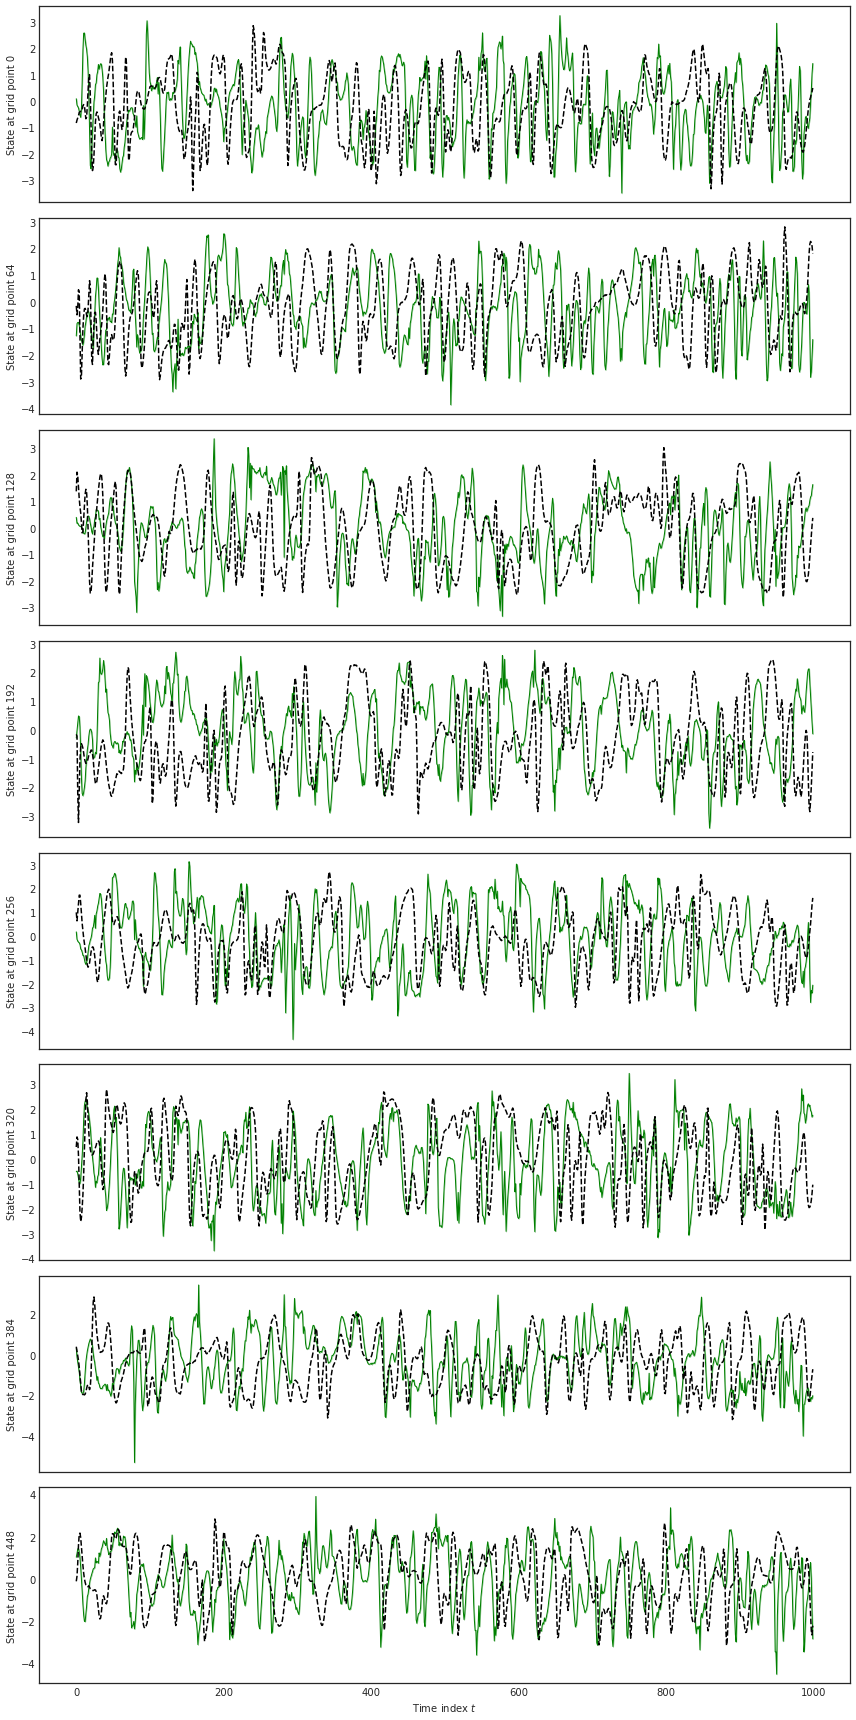

In [10]:
fig, axes = plot_results(
    results_enkf, range(0, n_grid, n_grid // 8), z_reference)

### Local ensemble transform Kalman filter

In [11]:
state_grid_coords = (np.arange(1, n_grid + 1) * 2 * np.pi * l_param / n_grid)[:, None]
state_grid_shape = (model.dim_z,)
obser_grid_coords = state_grid_coords[::obs_subsample]
localisation_radius = 4
localisation_func = da.PeriodicLocalisationFunction(
    state_grid_coords, obser_grid_coords, state_grid_shape,
    localisation_radius, use_cache=True
)

In [12]:
letkf = da.LocalEnsembleTransformKalmanFilter(
    model.init_state_sampler, model.next_state_sampler, model.observation_func,
    model.obser_noise_std * np.ones(model.dim_x), model.dim_z, localisation_func, 1.2, rng
)

In [13]:
%%time
results_letkf = letkf.filter(x_reference, 20, return_particles=True)

CPU times: user 4min 37s, sys: 6.04 s, total: 4min 43s
Wall time: 2min 21s


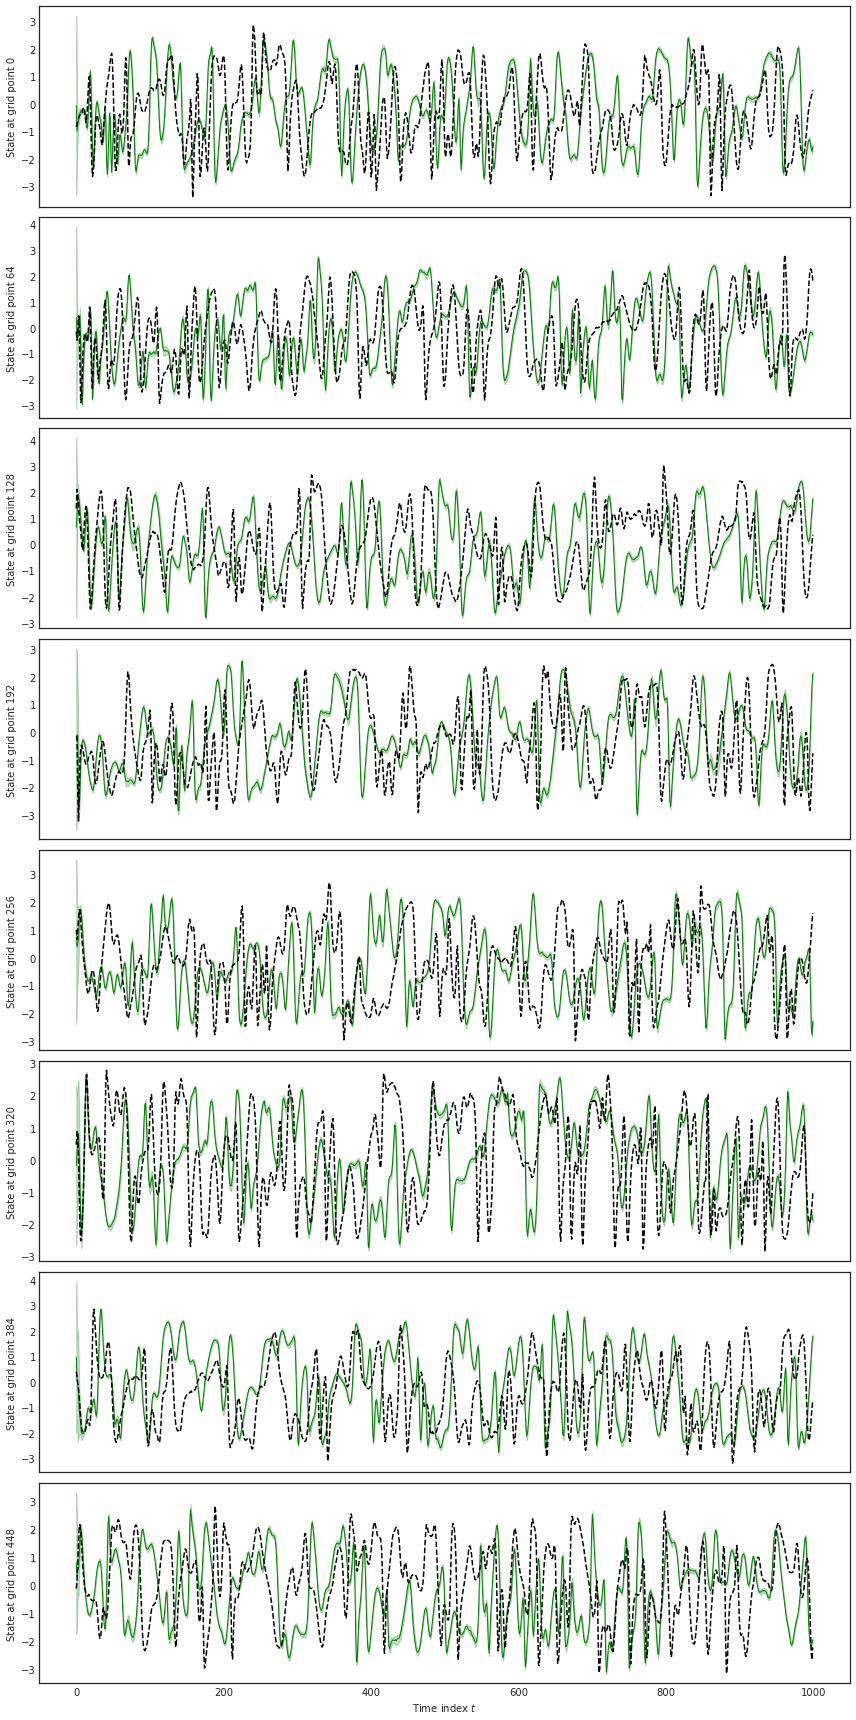

In [14]:
fig, axes = plot_results(
    results_letkf, range(0, n_grid, n_grid // 8), z_reference)

## Localised ensemble transform particle filter

In [21]:
state_grid_coords = (np.arange(1, n_grid + 1) * 2 * np.pi * l_param / n_grid)[:, None]
state_grid_shape = (model.dim_z,)
obser_grid_coords = state_grid_coords[::obs_subsample]
localisation_radius = 4
localisation_func = da.PeriodicLocalisationFunction(
    state_grid_coords, obser_grid_coords, state_grid_shape,
    localisation_radius, use_cache=True
)

In [22]:
letpf = da.LocalEnsembleTransformParticleFilter(
    model.init_state_sampler, model.next_state_sampler, model.observation_func,
    model.obser_noise_std * np.ones(model.dim_z), model.dim_z, localisation_func, 1.1, rng
)

In [23]:
%%time
results_letpf = letpf.filter(x_reference, 20, return_particles=True)

CPU times: user 2min 16s, sys: 144 ms, total: 2min 16s
Wall time: 2min 16s


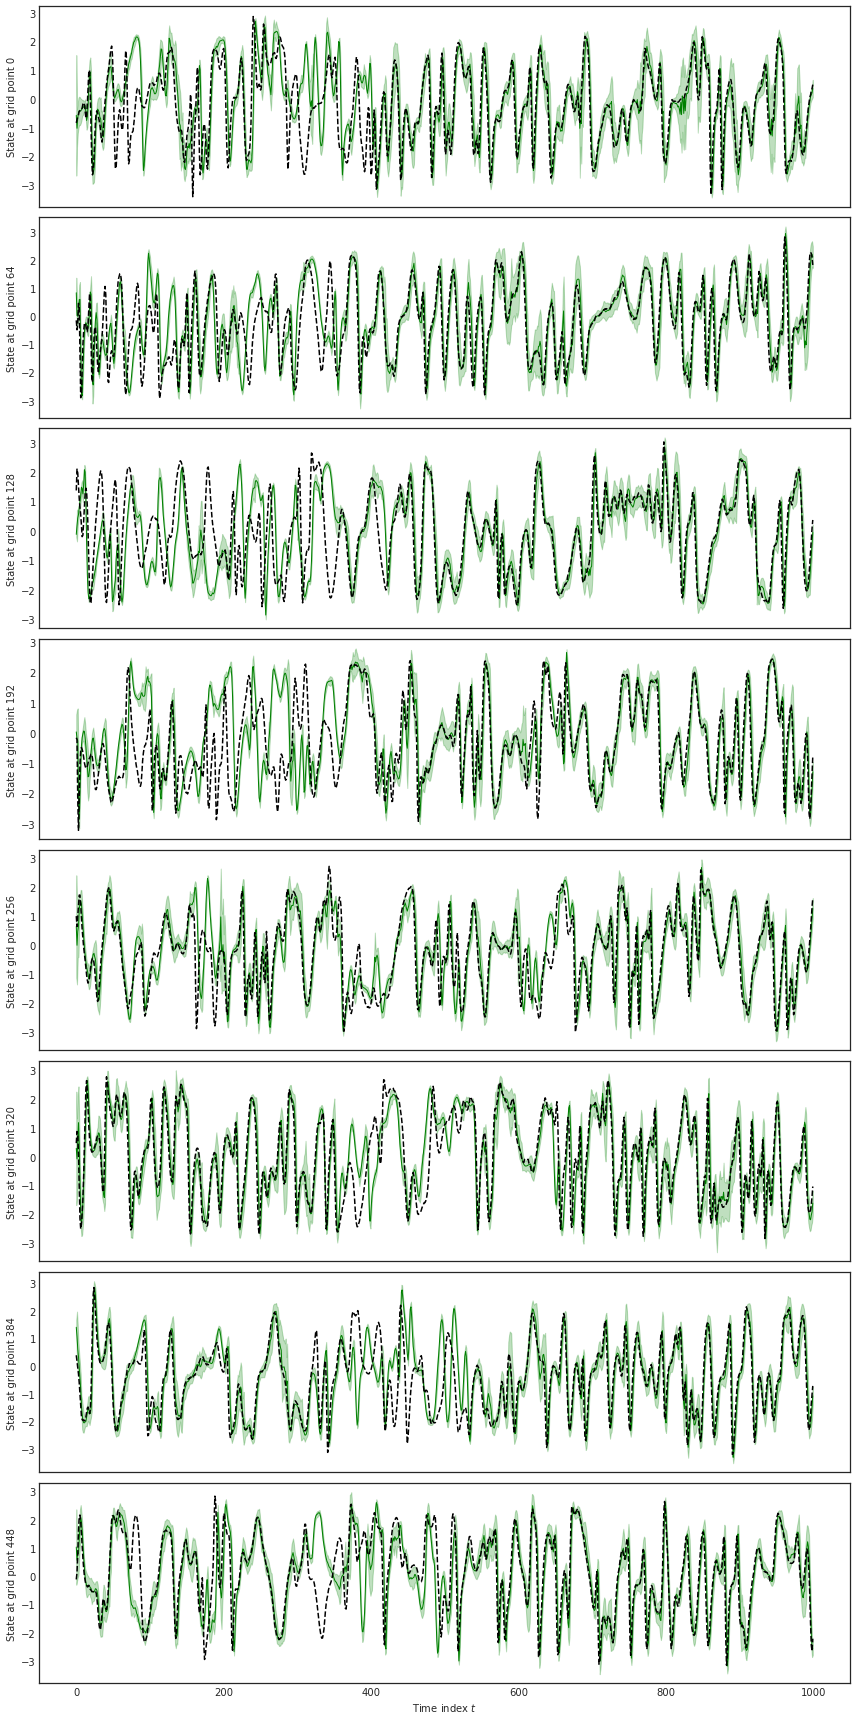

In [24]:
fig, axes = plot_results(
    results_letpf, range(0, n_grid, n_grid // 8), z_reference)

## Scalable localised ensemble transform particle filter

In [15]:
state_grid_coords = (np.arange(1, n_grid + 1) * 2 * np.pi * l_param / n_grid)[:, None]
state_grid_shape = (model.dim_z,)
obser_grid_coords = state_grid_coords[::obs_subsample]
localisation_radius = 4
localisation_kernel = da.PeriodicLocalisationFunction(
    obser_grid_coords, state_grid_coords, state_grid_shape,
    localisation_radius, use_cache=True
)

In [16]:
def log_likelihood_per_obs_loc(z_forecast, x_observed, time_index):
    x_forecast = model.observation_func(z_forecast, time_index)
    return -0.5 * (
        (x_forecast - x_observed[None])**2 / model.obser_noise_std**2)

In [17]:
n_bases = 32
pou_basis = pou.SquaredCosine1dPartitionOfUnityBasis(n_grid, n_bases)

In [18]:
sletpf = da.PouLocalEnsembleTransportParticleFilter(
    model.init_state_sampler, model.next_state_sampler, rng,
    log_likelihood_per_obs_loc, localisation_kernel, pou_basis, 0., None, 1.1)

In [19]:
%%time
results_sletpf = sletpf.filter(x_reference, 20, return_particles=True)

CPU times: user 17.6 s, sys: 44 ms, total: 17.7 s
Wall time: 17.7 s


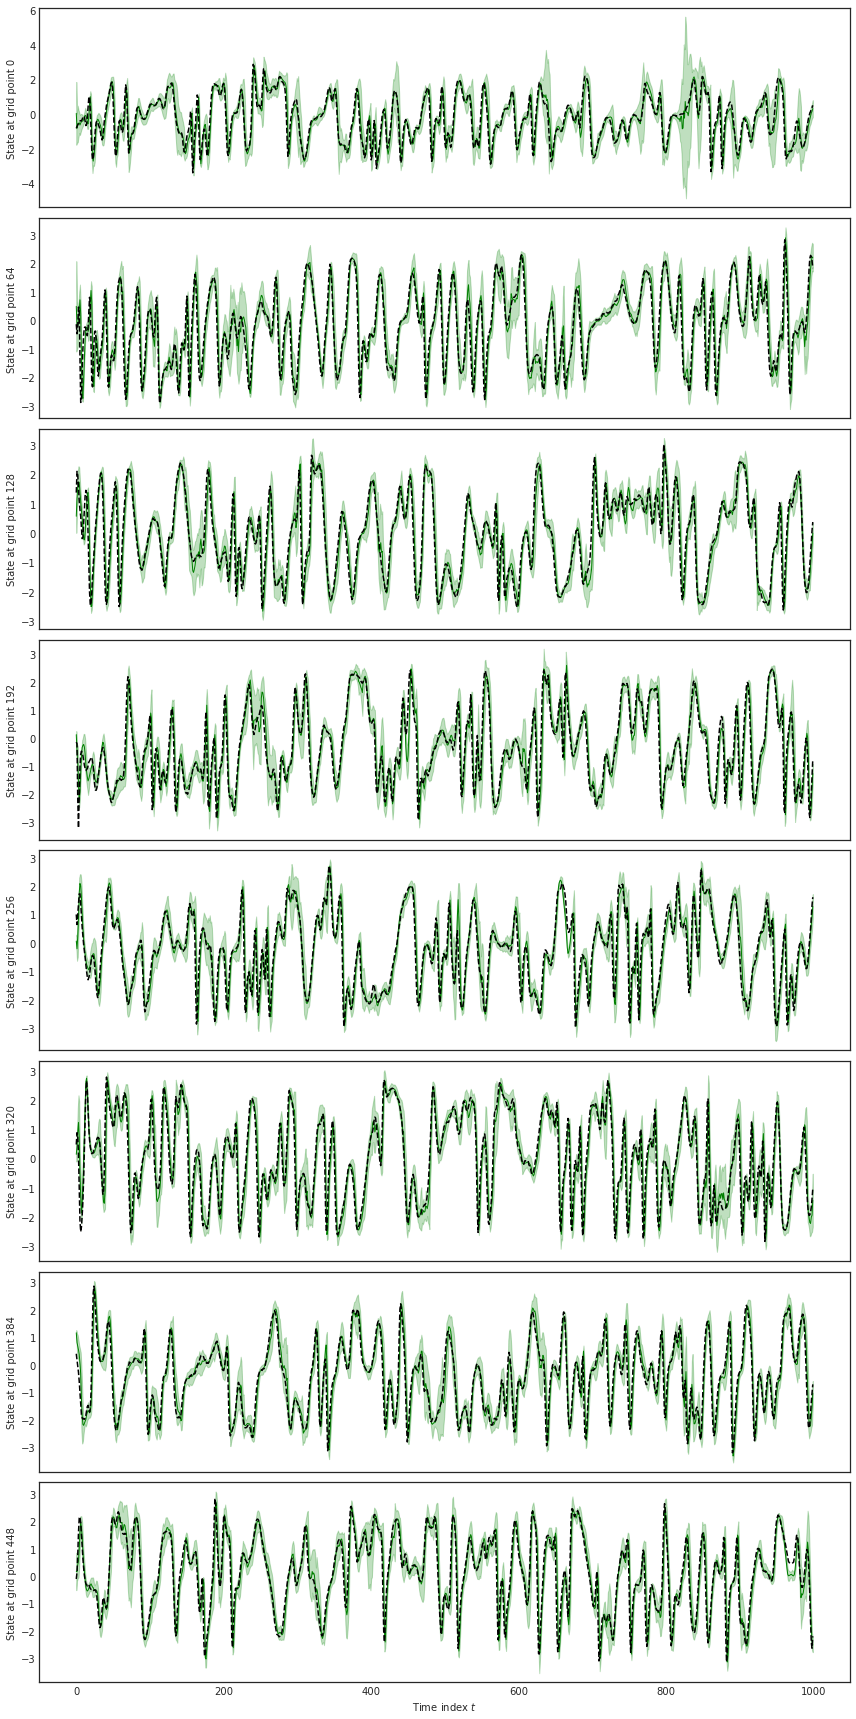

In [20]:
fig, axes = plot_results(
    results_sletpf, range(0, n_grid, n_grid // 8), z_reference)